<a href="https://colab.research.google.com/github/GermanOmar/Melting/blob/master/Eff_WAAM_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Melting efficiency in WAAM


<a href="https://ibb.co/5Rvr5t7"><img src="https://i.ibb.co/kS04hkd/Fig1-4.png" WIDTH="500" HEIGHT="300"  border="0"></a>

 Libraries

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import preprocessing
import warnings
warnings.filterwarnings("ignore")

 Upload database:

In [4]:
!git clone https://github.com/GermanOmar/Melting

fatal: destination path 'Melting' already exists and is not an empty directory.


In [5]:
#Experimental data
data = pd.read_table('dataset.txt') 
data.describe()



,WD,WFS,v,P,W,H,AW,eff
count,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000
mean,0.952632,96.237105,8.348553,2243.528816,5.585132,2.408947,12.305526,0.402895
std,0.172413,53.101644,5.188774,929.073636,1.325020,0.532447,5.339034,0.053086
min,0.800000,28.000000,1.660000,655.830000,2.520000,1.610000,4.450000,0.280000
25%,0.800000,54.877500,4.450000,1482.320000,4.607500,1.975000,7.587500,0.370000
50%,0.800000,84.000000,6.675000,2213.790000,5.575000,2.360000,11.325000,0.400000
75%,1.200000,123.665000,10.910000,2975.107500,6.407500,2.830000,16.815000,0.442500
max,1.200000,222.500000,25.000000,4032.780000,8.830000,3.620000,22.890000,0.570000



Setting inputs - output:

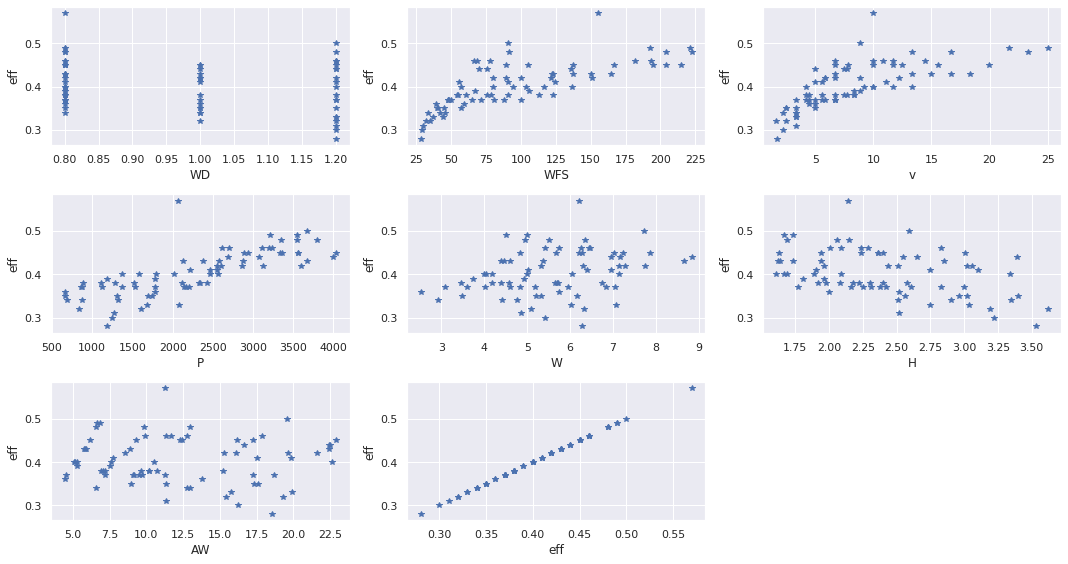

In [6]:
fields = ['WD', 'WFS','v','P','W','H', 'AW', 'eff']
import seaborn as sns
sns.set()

fig = plt.figure()
fig.set_size_inches((15,8))
for i, field in enumerate(fields):
  plt.subplot(3, 3, i + 1)
  plt.plot(data[field], data['eff'], 'b*')
  plt.xlabel(field)
  plt.ylabel('eff')

plt.tight_layout()

X=data[['WD', 'WFS','v','P','W','H', 'AW']]
Y=data['eff'][:,None]



#fig.tight_layout()

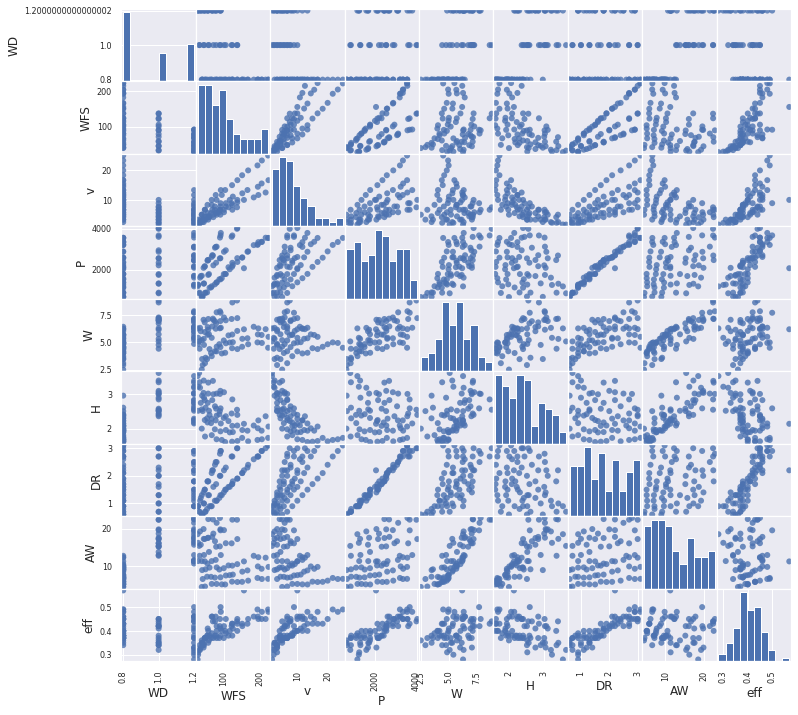

In [ ]:
from pandas.plotting import scatter_matrix
#DISPLAY MATRIX - identificar correlacion entre variables
scatter_matrix(data, alpha=0.8, marker='o', figsize = (12,12))
warnings.filterwarnings("ignore")

# Melting efficiency prediction

In [7]:
def normalize(X, X_mu, X_std):
  return (X - X_mu)/X_std

def denormalize(Xn, X_mu, X_std):
  return Xn*X_std + X_mu

X_std = X.std(0)
X_mu = X.mean(0)
Xn = normalize(X, X_mu, X_std)

Y_std = Y.std(0)
Y_mu = Y.mean(0)
Yn = normalize(Y, Y_mu, Y_std)

 Split data

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(Xn, Yn, test_size=0.2, random_state=1234)
print('training samples:', X_train.shape[0],  ' test samples:', X_test.shape[0])

training samples: 60  test samples: 16


Randomized search

In [18]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler

#Results:

# GPs

Gaussian Process
MSE train: 0.000267187082073796
MSE test: 0.019864199797926706
MSE train < MSE test? True

R2_train:  0.9997653949359036
R2_test:  0.9578590050978806

R2:  0.9578590050978806
RMSE:  0.14094041222419745
MAE:  0.12082112386178745
IM:  0.1903623051459835



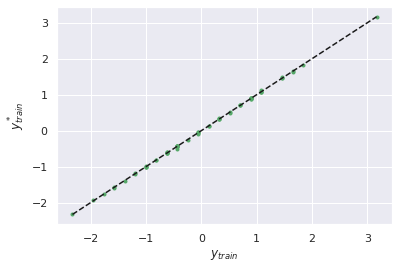

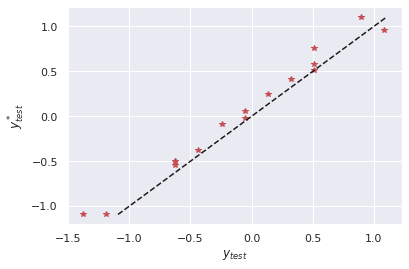

In [11]:
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
 
GP=GPR(alpha=0.001, copy_X_train=True,
                         kernel=1**2 * RBF(length_scale=10),
                         n_restarts_optimizer=20, normalize_y=True,
                         optimizer='fmin_l_bfgs_b', random_state=None)
 
#Training
GP.fit(X_train,y_train)
 
#Testing
y_star_train = GP.predict(X_train)
y_pred = GP.predict(X_test)
 
#Plots
plt.figure()
plt.plot(y_train, y_star_train, 'g.')
plt.plot([y_star_train.min(), y_star_train.max()], [y_star_train.min(), y_star_train.max()], 'k--')
plt.ylabel('$y^*_{train}$')
plt.xlabel('$y_{train}$')

plt.figure()
plt.plot(y_test, y_pred, 'r*')
plt.plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()], 'k--')
plt.ylabel('$y^*_{test}$')
plt.xlabel('$y_{test}$')
 
from sklearn.metrics import mean_squared_error
MSE_test = mean_squared_error(y_test, y_pred)
MSE_train = mean_squared_error(y_train, y_star_train)
 
print("Gaussian Process")
print('MSE train:', MSE_train)
print('MSE test:', MSE_test)
print("MSE train < MSE test?", MSE_train < MSE_test)
print()
from sklearn.metrics import r2_score
R2_train=r2_score(y_train, y_star_train)
print('R2_train: ',R2_train)
R2_test=r2_score(y_test, y_pred)
print('R2_test: ',R2_test)
print()
""" 
RE=100 * abs(y_test - y_pred) / y_test
print('Relative error (%): ',RE)
"""
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE 
#METRICS: R2, RMSE, MAE
R2=r2_score(y_test, y_pred)
print('R2: ',R2)
RMSE = np.sqrt(MSE_test)
print("RMSE: ", RMSE)
MAE = MAE(y_test, y_pred)
print("MAE: ", MAE)
IM=np.sqrt(((1-R2)**2) + (RMSE**2) + (MAE**2) )
print("IM: ", IM)
print()

In [ ]:
# initialize model and define the space of the hyperparameters to
# perform the grid-search over
model = GP
n_restarts_optimizer = [5, 10, 20]
alpha = [0.001, 0.1, 1, 10]


grid = dict(n_restarts_optimizer=n_restarts_optimizer, alpha=alpha )

In [ ]:
# initialize a cross-validation fold and perform a randomized-search
# to tune the hyperparameters
print("[INFO] grid searching over the hyperparameters...")
cvFold = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
randomSearch = RandomizedSearchCV(estimator=model, n_jobs=-1,
	cv=cvFold, param_distributions=grid,
	scoring="neg_mean_squared_error")
searchResults = randomSearch.fit(X_train, y_train)
# extract the best model and evaluate it
print("[INFO] evaluating...")
bestModel = searchResults.best_estimator_
print("R2: {:.2f}".format(bestModel.score(X_test, y_test)))
print(bestModel)

[INFO] grid searching over the hyperparameters...
[INFO] evaluating...
R2: 0.94
GaussianProcessRegressor(alpha=0.001, copy_X_train=True,
                         kernel=1**2 * RBF(length_scale=10),
                         n_restarts_optimizer=20, normalize_y=True,
                         optimizer='fmin_l_bfgs_b', random_state=None)


# XGB

In [12]:
import pickle
import xgboost as xgb

xgbr = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=1234,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=0)
xgbr.fit(X_train, y_train)
y_pred = xgbr.predict(X_test)

In [19]:
score = xgbr.score(X_train, y_train)  
print("Training score: ", score)

Training score:  0.9999993273541959


In [13]:
print("-XGBRegressor -")
print("------------------")

#EVAL
from sklearn.metrics import mean_squared_error as MSE
MSE_test = MSE(y_test, y_pred)

print('MSE test:', MSE_test)

print()

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE 

#METRICS: R2, RMSE, MAE
R2=r2_score(y_test, y_pred)
print('R2: ',R2)
RMSE = np.sqrt(MSE_test)
print("RMSE: ", RMSE)
MAE = MAE(y_test, y_pred)
print("MAE: ", MAE)
IM=np.sqrt(((1-R2)**2) + (RMSE**2) + (MAE**2) )
print("IM: ", IM)
print()

-XGBRegressor -
------------------
MSE test: 0.07647389904944904

R2:  0.8377641071489631
RMSE:  0.27653914560049003
MAE:  0.2190627253603962
IM:  0.38830768936623766



In [25]:
# initialize model and define the space of the hyperparameters to
# perform the grid-search over
model = xgbr
n_estimators = [100, 1000, 10000]
learning_rate = [0.1, 0.01, 1e-3]
max_depth = [5, 10, 20 ]

grid = dict(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth )

In [26]:
# initialize a cross-validation fold and perform a randomized-search
# to tune the hyperparameters
print("[INFO] grid searching over the hyperparameters...")
cvFold = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
randomSearch = RandomizedSearchCV(estimator=model, n_jobs=-1,
	cv=cvFold, param_distributions=grid,
	scoring="neg_mean_squared_error")
searchResults = randomSearch.fit(X_train, y_train)
# extract the best model and evaluate it
print("[INFO] evaluating...")
bestModel = searchResults.best_estimator_
print("R2: {:.2f}".format(bestModel.score(X_test, y_test)))
print(bestModel)

[INFO] grid searching over the hyperparameters...
[INFO] evaluating...
R2: 0.84
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=1234,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=0)


Feature: 0, Score: 0.01900
Feature: 1, Score: 0.16778
Feature: 2, Score: 0.08965
Feature: 3, Score: 0.64882
Feature: 4, Score: 0.02227
Feature: 5, Score: 0.02337
Feature: 6, Score: 0.02911


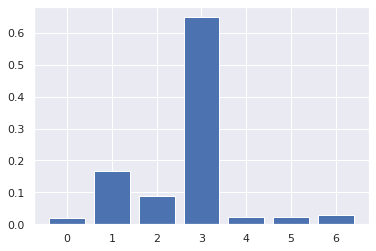

In [29]:
# get importance
importance = xgbr.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

#MLP

In [22]:
from sklearn.neural_network import MLPRegressor

MLP =MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=5, learning_rate='adaptive',
             learning_rate_init=0.001, max_fun=15000, max_iter=2000,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=1234, shuffle=True, solver='lbfgs',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)
#MLP = MLPRegressor(hidden_layer_sizes=(1000,1000,1000), activation='relu', solver='adam', max_iter=800)

#START TRAINING
MLP.fit(X_train,y_train)
#PREDICTION
y_pred=MLP.predict(X_test)

print()

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE 
R2_train=r2_score(y_train, y_star_train)
print('R2_train: ',R2_train)

#METRICS: R2, RMSE, MAE
R2=r2_score(y_test, y_pred)
print('R2: ',R2)
RMSE = np.sqrt(MSE_test)
print("RMSE: ", RMSE)
MAE = MAE(y_test, y_pred)
print("MAE: ", MAE)
IM=np.sqrt(((1-R2)**2) + (RMSE**2) + (MAE**2) )
print("IM: ", IM)
print()


R2_train:  0.9997653949359036
R2:  0.786274758574558
RMSE:  0.27653914560049003
MAE:  0.22506919915143225
IM:  0.4157024443980088



In [20]:
# initialize model and define the space of the hyperparameters to
# perform the grid-search over
model = MLP
hidden_layer_sizes = [5, 8, 10]
activation = ['relu','tanh']
solver = ["lbfgs", "sgd", "adam"]

grid = dict(hidden_layer_sizes=hidden_layer_sizes, activation=activation, solver=solver )

In [21]:
# initialize a cross-validation fold and perform a randomized-search
# to tune the hyperparameters
print("[INFO] grid searching over the hyperparameters...")
cvFold = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1234)
randomSearch = RandomizedSearchCV(estimator=model, n_jobs=-1,
	cv=cvFold, param_distributions=grid,
	scoring="neg_mean_squared_error")
searchResults = randomSearch.fit(X_train, y_train)
# extract the best model and evaluate it
print("[INFO] evaluating...")
bestModel = searchResults.best_estimator_
print("R2: {:.2f}".format(bestModel.score(X_test, y_test)))
print(bestModel)

[INFO] grid searching over the hyperparameters...
[INFO] evaluating...
R2: 0.79
MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=5, learning_rate='adaptive',
             learning_rate_init=0.001, max_fun=15000, max_iter=2000,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=1234, shuffle=True, solver='lbfgs',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)


## Comparisson

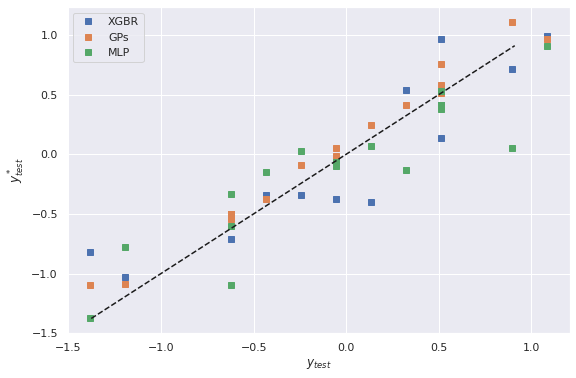

In [28]:
models = [ xgbr,  GP, MLP]
labels = ['XGBR',  'GPs', 'MLP']

fig = plt.figure()
fig.set_size_inches((9,6))

for mod, label in zip( models, labels): 
  y_pred = mod.predict(X_test)
  plt.plot(y_test, y_pred, 's' ,label = label)

plt.plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()], 'k--')
plt.ylabel('$y^*_{test}$')
plt.xlabel('$y_{test}$')
plt.legend()  
  

CROSS-VALIDATION

In [27]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error 
from sklearn.model_selection import cross_val_score as CV

import warnings
warnings.filterwarnings('ignore')

models = [ xgbr,  GP, MLP]
labels = ['XGBR', 'GPs', 'MLP']
IMS = []

print("--------------------------------------------------------------")
print("%5s | %5s | %5s | %5s | %5s " % ("ML algorithm",  "CV-R2", "CV-MSE", "CV-MAE", "IM"))
print("--------------------------------------------------------------")

for mod, label in zip( models, labels): 
  y_star_train = mod.predict(X_train)
 
  scoreR2 = CV(mod, Xn, Yn, cv=5, scoring='r2')
  #print(-1*scoreR2)
  scoreMSE = CV(mod, Xn, Yn, cv=5, scoring='neg_mean_squared_error')
  #print(-1*scoreMSE)
  scoreMAE = CV(mod, Xn, Yn, cv=5, scoring='neg_mean_absolute_error')
  #print(-1*scoreMAE)
  IM=np.sqrt(((1-scoreR2)**2) + (scoreMSE) + (scoreMAE**2) )
  #print("IM: ", IM)
  
 
  print("%15s | %.4f | %.4f | %.4f | %.4f " % (label,  scoreR2.mean(), -1*scoreMSE.mean(), -1*scoreMAE.mean() , np.sqrt(((1-scoreR2.mean())**2) + (-1*scoreMSE.mean()) + (scoreMAE.mean()**2) )))
print("--------------------------------------------------------------")

--------------------------------------------------------------
ML algorithm | CV-R2 | CV-MSE | CV-MAE |    IM 
--------------------------------------------------------------
           XGBR | 0.7292 | 0.2864 | 0.3434 | 0.6911 
            GPs | 0.8557 | 0.1358 | 0.3043 | 0.4993 
            MLP | 0.0752 | 0.7664 | 0.5749 | 1.3972 
--------------------------------------------------------------
